# Not yet finished. Generative Adveserial Network

### What is a Generative Model ?

Given a set of data instances X and a set of labels Y:
+ Generative model captures the joint probability p(X,Y)(ergo p(X) if there are no labels).
+ Discriminative models capture the conditional probability p(Y|X).


![alt text](https://developers.google.com/machine-learning/gan/images/generative_v_discriminative.png "1")



In [6]:
# https://colab.research.google.com/github/tensorflow/gan/blob/master/tensorflow_gan/examples/colab_notebooks/tfgan_tutorial.ipynb?utm_source=ss-gan&utm_campaign=colab-external&utm_medium=referral&utm_content=tfgan-intro
    
# https://github.com/tensorflow/gan/tree/master/tensorflow_gan/examples    

# Generative Adversarial Networks (GAN) example in PyTorch. Tested with PyTorch 0.4.1, Python 3.6.7 (Nov 2018)
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9



In [10]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


# Data params
data_mean = 4
data_stddev = 1.25

# ### Uncomment only one of these to define what data is actually sent to the Discriminator
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
print("Using data [%s]" % (name))


# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

Using data [Only 4 moments]


In [11]:
# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))
    
    
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]





def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

Epoch 0: D (0.5796899199485779 real_err, 0.8135262727737427 fake_err) G (0.5874426960945129 err); Real Dist ([3.856142955839634, 1.2598316232339977]),  Fake Dist ([0.2578824281692505, 0.04977261993244023]) 
Plotting the generated distribution...
 Values: [0.27418190240859985, 0.18437938392162323, 0.30481383204460144, 0.2385162115097046, 0.30528706312179565, 0.22785300016403198, 0.2752673625946045, 0.25673454999923706, 0.3484914302825928, 0.3237861692905426, 0.22758591175079346, 0.23789098858833313, 0.273847758769989, 0.2915406823158264, 0.25253579020500183, 0.3432212769985199, 0.34097620844841003, 0.18416377902030945, 0.2501744031906128, 0.24122552573680878, 0.1966744065284729, 0.18684649467468262, 0.21074345707893372, 0.21641725301742554, 0.22570759057998657, 0.24114209413528442, 0.18642492592334747, 0.2777791917324066, 0.2772972881793976, 0.21125105023384094, 0.19440101087093353, 0.18927758932113647, 0.3485107421875, 0.29451313614845276, 0.3444976508617401, 0.20848943293094635, 0.272

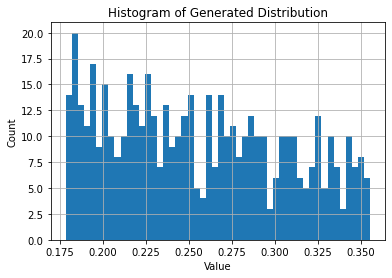

In [17]:


def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 1#5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    
    # Generator.
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    # Disc.
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones(d_real_decision.shape)))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params
            
            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(d_fake_decision.shape)))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    print("Plotting the generated distribution...")
    values = extract(g_fake_data)
    print(" Values: %s" % (str(values)))
    plt.hist(values, bins=50)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Histogram of Generated Distribution')
    plt.grid(True)
    plt.show()
    

train()